In [1]:
!pip install transformers
!pip install bertviz
!pip install umap-learn
!pip install accelerate
!pip install datasets
!pip install nltk
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import cv2
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
from PIL import Image, ImageFile
import numba
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import re

from transformers import pipeline
from datasets import load_dataset


%matplotlib inline

##Датасеты

In [3]:
df_text_test = pd.read_csv('df_text_test-2.csv')

In [13]:
"""
    Dataset for ViT с фильтрацией лэйбла content
"""

ds = load_dataset("tukey/human_face_emotions_roboflow")
ds = ds.filter(lambda example, indice: example['qa'][0]["answer"] != "content", with_indices=True)



In [14]:
ds_split_train_test = ds["train"].train_test_split(test_size=0.15)
train_ds, eval_ds = ds_split_train_test["train"], ds_split_train_test["test"]

ds_split_train_test = train_ds.train_test_split(test_size=0.15)
train_ds, test_ds = ds_split_train_test["train"], ds_split_train_test["test"]

In [15]:
test_ds

Dataset({
    features: ['image', 'qa'],
    num_rows: 1053
})

In [5]:
def ClassesIndNameConnection():
    """
    Словари для перехода от имени лэйбла к его номеру и наоборот  Distilbert

    return:  class_to_name, name_to_class
    """

    unique_values = df_text_test['label'].unique()
    unique_values_ = df_text_test['label_name'].unique()

    class_to_name = dict(zip(unique_values, unique_values_))

    name_to_class = {}
    for key in class_to_name:
        name_to_class[class_to_name[key]] = key

    return class_to_name, name_to_class

In [6]:
class_to_name, name_to_class = ClassesIndNameConnection()

In [7]:
Distilbert = pipeline("text-classification", model="VK26/disilbert-finetuned-emotion2")

def DistilbertInference(prompt):
        """
        Функция принимает промпт и возращает предсказание затюниного t

        return: label_name, label, best_logit
        """

        preds = Distilbert(prompt)
        preds = sorted(preds, key=lambda item: item["score"], reverse=True)
        class_number = int(preds[0]["label"][-1])
        return class_to_name[class_number], class_number,  preds[0]['score']

config.json:   0%|          | 0.00/875 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

Device set to use cuda:0


In [8]:
"""
    Словари для перехода от имени лэйбла к его номеру и наоборот ViT
"""

tok_to_ind = {'sad': 0,
 'anger': 1,
 'neutral': 2,
 'fear': 3,
 'content': 4,
 'happy': 5,
 'disgust': 6,
 'surprise': 7}

ind_to_tok = {}
for key in tok_to_ind:
    ind_to_tok[tok_to_ind[key]] = key

In [9]:
ViT = pipeline("image-classification", model="VK26/ViT-finetuned-emotion")

config.json:   0%|          | 0.00/936 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [10]:
def ViTInference(img):
        """
        Функция принимает промпт (картинку) и возращает предсказание затюниного ViT

        return: label_name, label, best_logit
        """
        preds = ViT(img)
        class_ = preds[0]["label"]
        return class_, tok_to_ind[class_],  preds[0]['score']

In [ ]:
def CompareInferenceTrue():
    """ Сопоставляет предсказаное значение лэйбла с действительным
        Иллюстрация в виде тепловой карты.

        return: heat_map
    """

    heat_map = np.zeros((7, 7))
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        prediction = DistilbertInference(row["text"])[1]
        true = row["label"]

        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()

    return heat_map

a = CompareInferenceTrue()

Total: 5535it [10:57,  8.42it/s]


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, Text
from nltk.probability import FreqDist
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

def MostPopularWords(dataset=True):
    """
        dataset=True - по исходному датасету
        dataset=False - по предсказаниям модели

        Функция возвращает словарь, где
        по лэйблу можно получить вложеный словарь с:
        "freq" - список пар  ( слово - частота )
        "text" - текст, очищенный от стопслов для генерации облаков слов
    """
    cnt = {}
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        text = row["text"]
        label = row["label"] if dataset else DistilbertInference(row["text"])[1]

        if not label in list(cnt.keys()):
            cnt[label] = []

        text = re.sub(r'[^\w\s]', '', text).strip().lower()
        text = text.split()
        cnt[label] += text

    _stopwords = stopwords.words("english")
    for label in cnt:
        _string = " ".join(cnt[label])
        text_tokens = word_tokenize(_string)
        text_tokens = [token.strip() for token in text_tokens if token not in _stopwords]
        cnt[label] = {}
        cnt[label]["text"] = nltk.Text(text_tokens)
        cnt[label]["freq"] = FreqDist(cnt[label]["text"])

    return cnt

def DrowFreqHisto(cnt):
    """
        Рисует топ 7 самых частых слов для каждого лэйбла
    """
    counter = 7
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    points = {"0" : {0 : 0}, "1" : {0 : 1}, "2" : {1 : 0}, "3" : {1 : 1}, "4" : {1 : 2}, "5" : {2 : 1}, "6" : {2 : 2}}
    for i in range(7):
        words_freqs = cnt[i]["freq"]
        words_freqs = sorted(words_freqs.items(), key=lambda item: item[1], reverse=True)
        words, freqs = zip(*(words_freqs[:counter]))
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].set_title(class_to_name[i])
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].barh(words, freqs)




def DrowWordCloud(cnt):
    """
        Рисует облака слов  для каждого лэйбла
    """
    counter = 7
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    points = {"0" : {0 : 0}, "1" : {0 : 1}, "2" : {1 : 0}, "3" : {1 : 1}, "4" : {1 : 2}, "5" : {2 : 1}, "6" : {2 : 2}}
    for i in range(7):
        text = cnt[i]["text"]
        text_raw = " ".join(text)
        wordcloud = WordCloud(width=1600, height=800).generate(text_raw)
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].set_title(class_to_name[i])
        axs[list(points[str(i)].keys())[0], list(points[str(i)].values())[0]].imshow(wordcloud)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
count_words_by_categories = MostPopularWords(dataset=True)

Total: 5535it [00:00, 15391.76it/s]


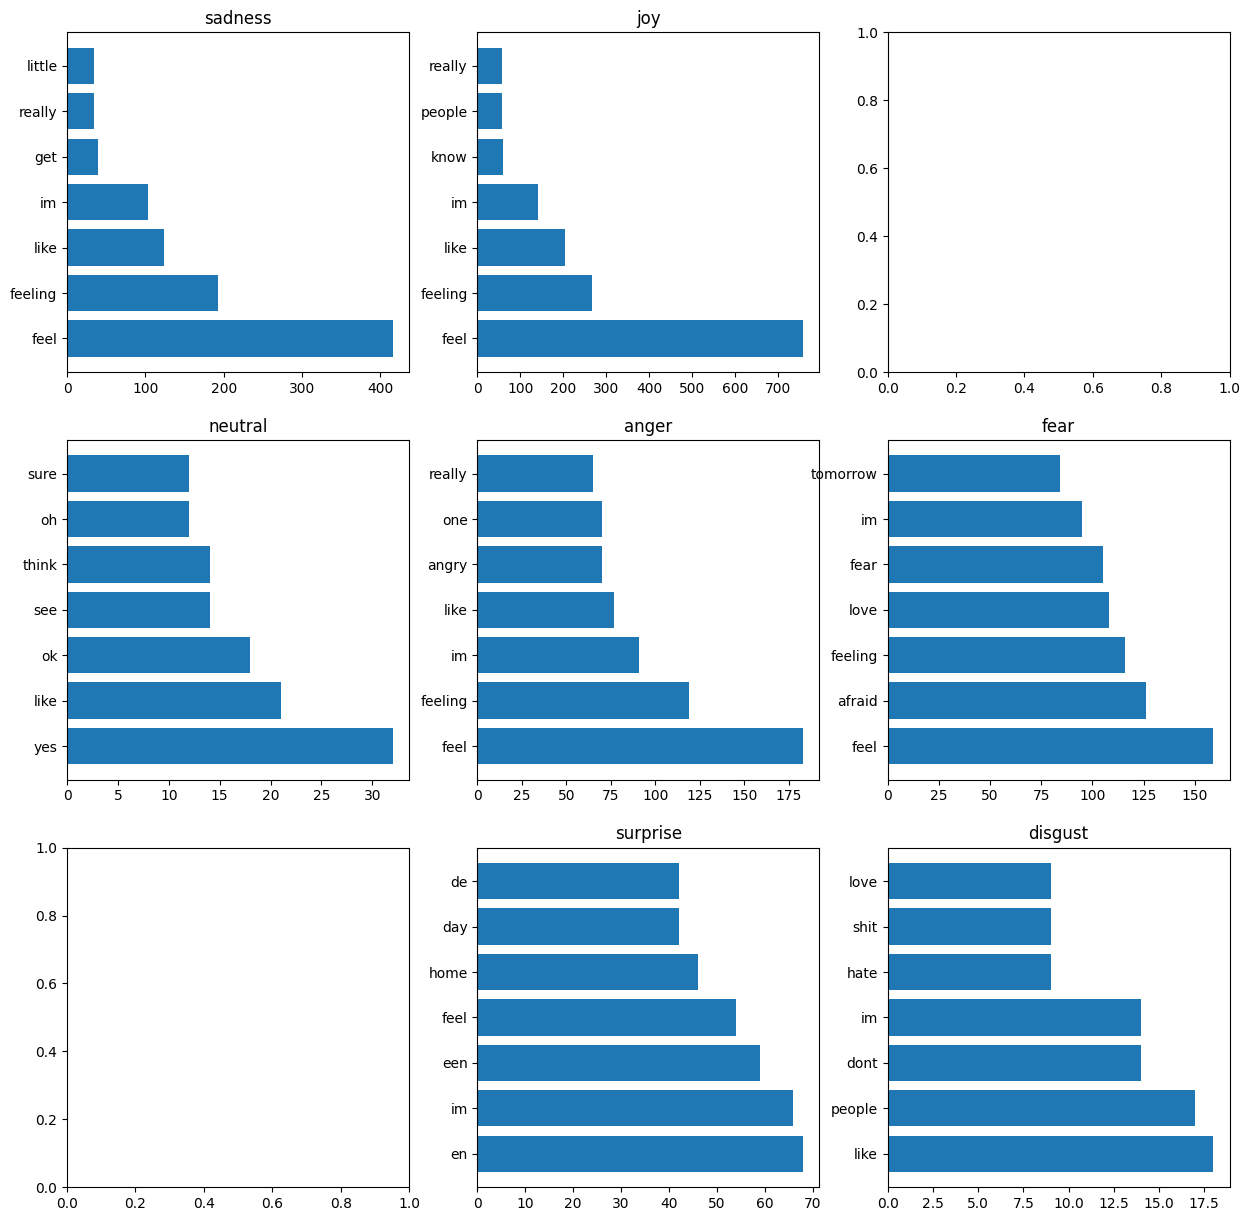

In [ ]:
DrowFreqHisto(count_words_by_categories)

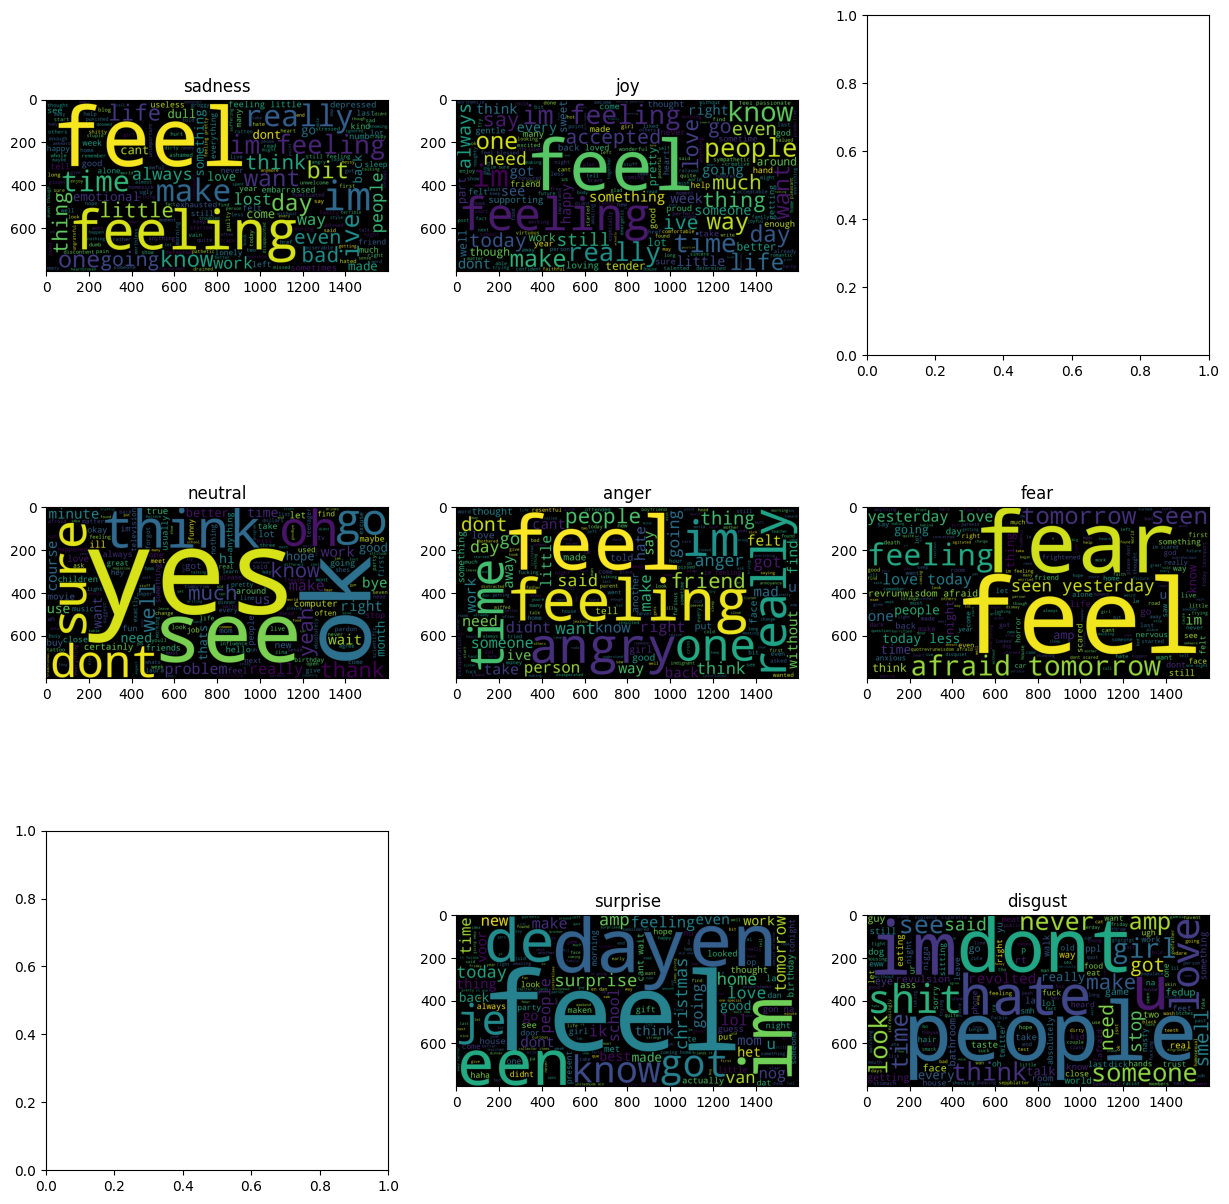

In [ ]:
DrowWordCloud(count_words_by_categories)

In [ ]:
count_words_by_categories_inf = MostPopularWords(dataset=False)

Total: 5535it [08:09, 11.32it/s]


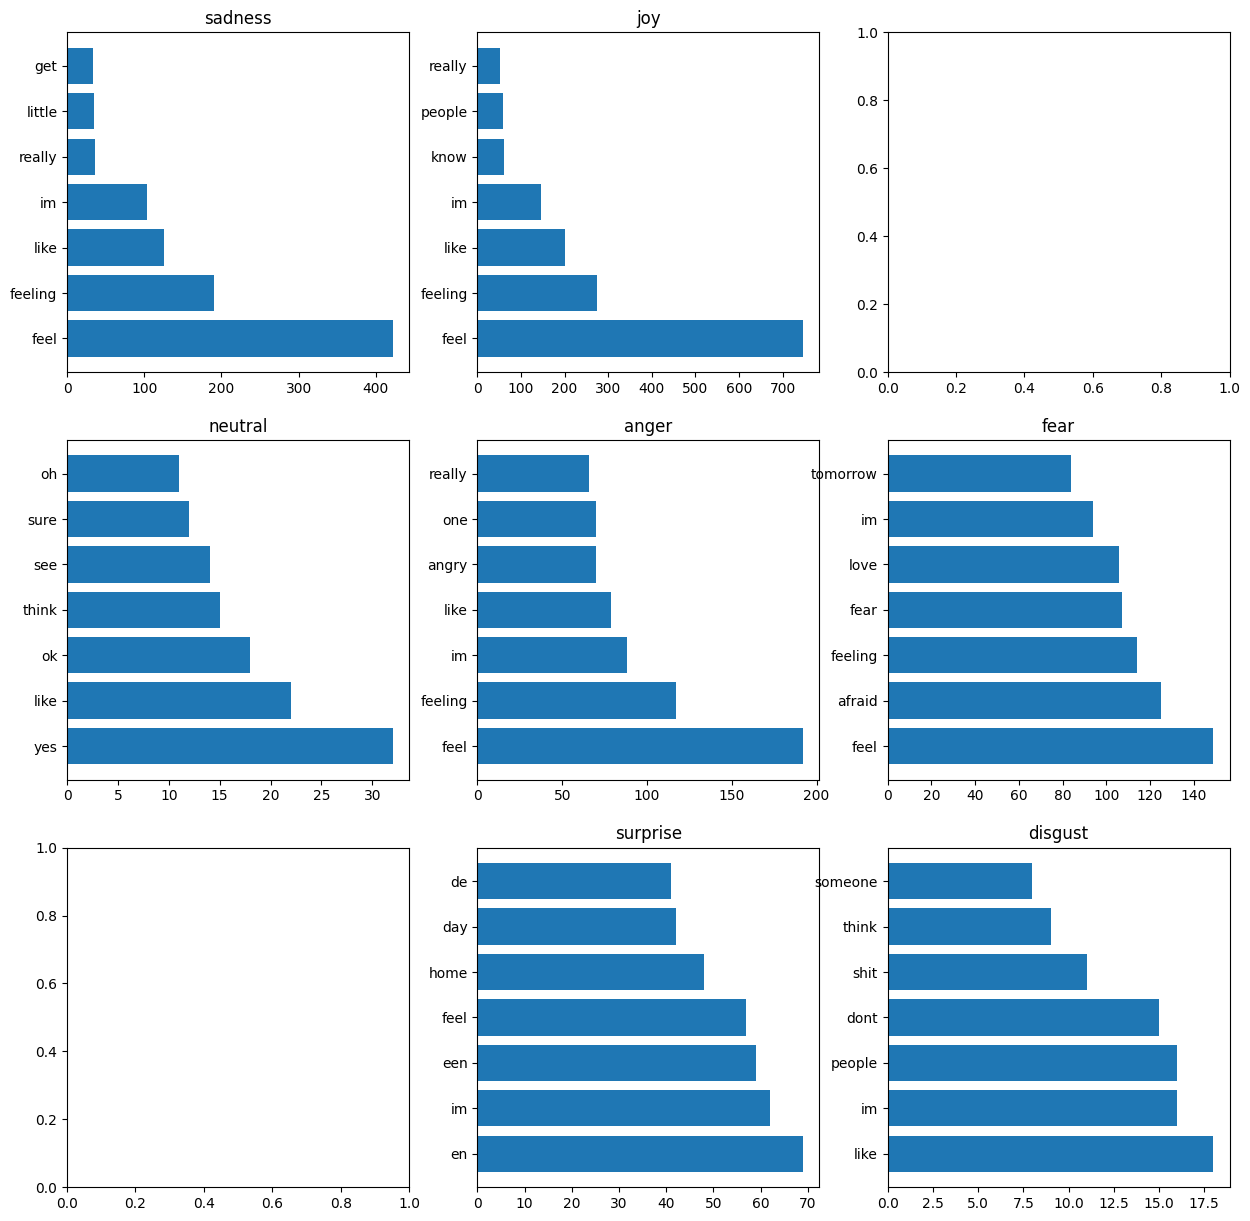

In [ ]:
DrowFreqHisto(count_words_by_categories_inf)

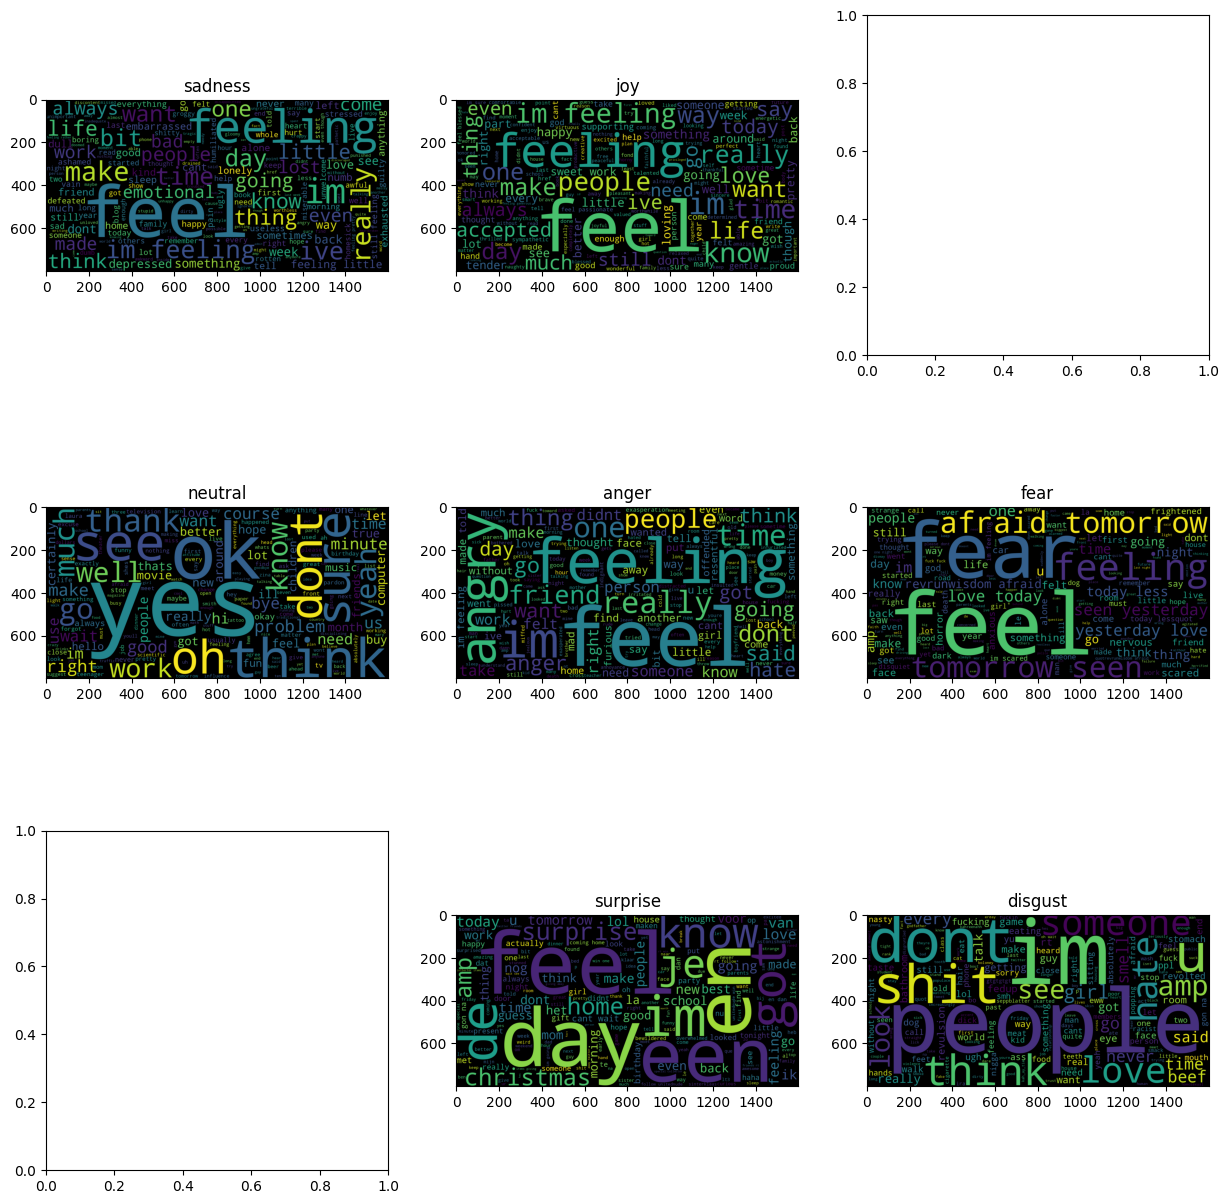

In [ ]:
DrowWordCloud(count_words_by_categories_inf)

In [ ]:
def FromBoxModelInference(prompt):
        """
        Функция принимает промпт и возращает предсказание затюниного Distilbert
        из промпта удаленяются супер частотные слова

        return: label_name, label, best_logit
        """
        prompt = prompt.split()
        for i in range(len(prompt), -1):
            if prompt[i] in ["feel", "feeling", "en", "de", "im", "een"]:
                prompt.pop(i)

        prompt = "".join(prompt)
        preds = Distilbert(prompt)
        preds = sorted(preds, key=lambda item: item["score"], reverse=True)

        class_number = int(preds[0]["label"][-1])
        return class_to_name[class_number], class_number,  preds[0]['score']


def InferenceFails():
    """ Сопоставляет предсказаное значение лэйбла с действительным
        Со скорректированным промптом для Distilbert

        Иллюстрация в виде тепловой карты.

        return: heat_map
    """
    heat_map = np.zeros((7, 7))
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        prediction = FromBoxModelInference(row["text"])[1]
        true = row["label"]

        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(class_to_name.values()),
                   y=list(class_to_name.values()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()

    return heat_map

a = InferenceFails()

Total: 5535it [07:44, 11.91it/s]


Total: 5535it [00:29, 190.53it/s]


ValueError: `bins` must increase monotonically, when an array

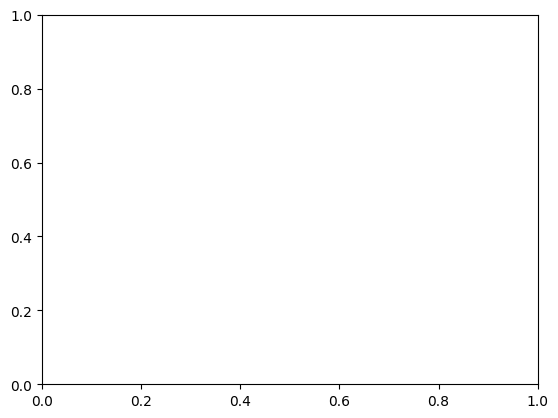

In [23]:
def InferenceFromLenght():
    """
        Зависимость качества предсказания от длины промпта
    """
    len_ = []
    true_or_false = []
    for ind, row in tqdm(df_text_test.iterrows(), ncols=80, ascii=True, desc='Total'):
        len_.append(len(row["text"].split()))
        prediction = DistilbertInference(row["text"])[1]
        true = row["label"]
        if prediction == true:
            true_or_false.append(1)
        else:
            true_or_false.append(0)

    len_and_tags = zip(len_, true_or_false)
    len_and_tags = sorted(len_and_tags, key=lambda x: x[0])


    x_len, y_accur = [10*i for i in range(13)], [0]*12
    curr = 0
    count = 0
    for Length, flag in len_and_tags:
        if Length < x_len[curr]:
            y_accur[curr] += flag
            count += 1
        else:
            if count > 0:
                y_accur[curr] = y_accur[curr] / count
            count = 0
            curr += 1
            y_accur[curr] += flag
            count += 1


    return x_len, y_accur

x, y = InferenceFromLenght()


Text(0.5, 1.0, 'accuracy vs length')

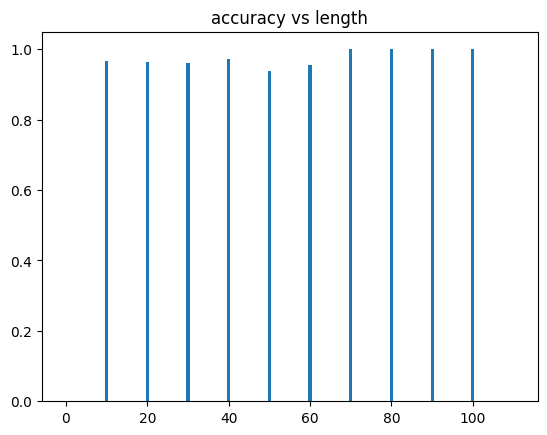

In [31]:
plt.bar(x[:12], y)
plt.title("accuracy vs length")

In [27]:
print(x[:11], y[:11])

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] [0, 0.9669621273166801, 0.9633715798764343, 0.960028551034975, 0.9733656174334141, 0.9387755102040817, 0.9565217391304348, 1.0, 1.0, 1.0, 1]


In [19]:
from tqdm import trange

def CompareInferenceTrueViT():
    """ Сопоставляет предсказаное значение ViT лэйбла с действительным
        Иллюстрация в виде тепловой карты.

        return: heat_map
    """
    mmp = {'sad': 0,
            'anger': 1,
            'neutral': 2,
            'fear': 3,
            'happy': 4,
            'disgust': 5,
            'surprise': 6}

    heat_map = np.zeros((7, 7))
    for i in trange(1053):
        prediction = ViTInference(test_ds[i]["image"])[1]
        true = tok_to_ind[test_ds[i]['qa'][0]["answer"]]
        if prediction==4 or true==4:
            continue
        if prediction>4:
            prediction -= 1
        if true>4:
            true -= 1
        heat_map[prediction][true] += 1

    fig1 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=heat_map,
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))

    fig2 = go.Figure(data=go.Heatmap(
                   z=heat_map / heat_map.sum(axis=0),
                   text=np.round(heat_map / heat_map.sum(axis=0), decimals=2),
                   texttemplate="%{text}",
                   textfont={"size":20},
                   x=list(mmp.keys()),
                   y=list(mmp.keys()),
                   hoverongaps = False))
    fig1.show()
    fig2.show()

    return heat_map

a = CompareInferenceTrueViT()

100%|██████████| 1053/1053 [00:34<00:00, 30.54it/s]
